# Exploratory Data Analysis - NYC Citi Bike Demand

This notebook provides comprehensive exploratory data analysis of:
- Bike station data and availability patterns
- Weather conditions and their impact on demand
- Temporal patterns (hourly, daily, weekly, seasonal)
- Correlations and feature relationships
- Data quality and anomalies

## Setup and Imports

In [16]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Standard libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Project imports
from src.data.collectors.citi_bike_collector import CitiBikeCollector
from src.data.collectors.weather_collector import WeatherCollector
from src.data.storage.postgres_handler import PostgreSQLHandler

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Plotly settings
import plotly.io as pio
pio.templates.default = "plotly_white"

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 1. Data Collection

We'll collect fresh data from NYC Citi Bike and OpenWeatherMap APIs

In [17]:
# Initialize collectors
bike_collector = CitiBikeCollector()
weather_collector = WeatherCollector()

print("🚴 Collecting bike station data...")
with bike_collector:
    # Collect station information
    stations_response = bike_collector.collect_station_information()
    stations = stations_response['data']['stations']
    print(f"✅ Collected {len(stations)} bike stations")
    
    # Collect current status
    statuses_response = bike_collector.collect_station_status()
    statuses = statuses_response['data']['stations']
    print(f"✅ Collected {len(statuses)} station statuses")

# NYC coordinates (Manhattan)
nyc_lat = 40.7128
nyc_lon = -74.0060

print("\n🌤️ Collecting weather data...")
with weather_collector:
    weather_result = weather_collector.collect(lat=nyc_lat, lon=nyc_lon)
    weather = weather_result['weather_data']
    print(f"✅ Collected weather data for NYC")

print("\n📊 Data collection complete!")

2025-12-25 22:44:31.003 | INFO     | src.data.collectors.citi_bike_collector:collect_station_information:57 - Collecting Citi Bike station information
2025-12-25 22:44:31.003 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://gbfs.citibikenyc.com/gbfs/en/station_information.json


🚴 Collecting bike station data...


2025-12-25 22:44:31.827 | DEBUG    | src.data.collectors.base_collector:make_request:90 - Successfully received data from https://gbfs.citibikenyc.com/gbfs/en/station_information.json
2025-12-25 22:44:31.828 | DEBUG    | src.data.collectors.citi_bike_collector:validate_station_information:160 - Station information validation passed
2025-12-25 22:44:31.828 | INFO     | src.data.collectors.citi_bike_collector:collect_station_information:61 - Successfully collected 2322 stations
2025-12-25 22:44:31.830 | INFO     | src.data.collectors.citi_bike_collector:collect_station_status:96 - Collecting Citi Bike station status
2025-12-25 22:44:31.831 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://gbfs.citibikenyc.com/gbfs/en/station_status.json


✅ Collected 2322 bike stations


2025-12-25 22:44:32.505 | DEBUG    | src.data.collectors.base_collector:make_request:90 - Successfully received data from https://gbfs.citibikenyc.com/gbfs/en/station_status.json
2025-12-25 22:44:32.506 | DEBUG    | src.data.collectors.citi_bike_collector:validate_station_status:208 - Station status validation passed
2025-12-25 22:44:32.507 | INFO     | src.data.collectors.citi_bike_collector:collect_station_status:100 - Successfully collected status for 2322 stations
2025-12-25 22:44:32.509 | DEBUG    | src.data.collectors.base_collector:close:124 - Collector session closed
2025-12-25 22:44:32.510 | INFO     | src.data.collectors.weather_collector:collect:120 - Starting weather data collection for NYC
2025-12-25 22:44:32.510 | DEBUG    | src.data.collectors.weather_collector:collect_current_weather:59 - Collecting weather for (40.7128, -74.006)
2025-12-25 22:44:32.511 | DEBUG    | src.data.collectors.base_collector:make_request:77 - Making GET request to https://api.openweathermap.org

✅ Collected 2322 station statuses

🌤️ Collecting weather data...
✅ Collected weather data for NYC

📊 Data collection complete!


## 2. Data Preparation

In [18]:
# Convert to DataFrames
df_stations = pd.DataFrame(stations)
df_statuses = pd.DataFrame(statuses)

# Add timestamp
current_time = datetime.utcnow()
df_statuses['timestamp'] = current_time

print(f"📋 Station Information Shape: {df_stations.shape}")
print(f"📋 Station Status Shape: {df_statuses.shape}")

# Display sample data
print("\n🔍 Sample Station Information:")
display(df_stations.head())

print("\n🔍 Sample Station Status:")
display(df_statuses.head())

📋 Station Information Shape: (2322, 15)
📋 Station Status Shape: (2322, 15)

🔍 Sample Station Information:


,lon,region_id,eightd_has_key_dispenser,eightd_station_services,external_id,lat,electric_bike_surcharge_waiver,capacity,name,has_kiosk,station_type,rental_uris,station_id,rental_methods,short_name
0,-73.98,71,False,[],66dc7ba2-0aca-11e7-82f6-3863bb44ef7c,40.73,False,43,E 14 St & Ave B,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",66dc7ba2-0aca-11e7-82f6-3863bb44ef7c,"[KEY, CREDITCARD]",5736.09
1,-73.92,71,False,[],498d7e8e-5164-4f26-9ce6-399947d73b1a,40.71,False,17,Suydam St & St Nicholas Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",498d7e8e-5164-4f26-9ce6-399947d73b1a,"[KEY, CREDITCARD]",5043.06
2,-73.93,71,False,[],1905837242740508940,40.76,False,35,31 St & Broadway,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",1905837242740508940,"[KEY, CREDITCARD]",6789.20
3,-74.00,71,False,[],a47f77a2-9008-4652-a4f1-b95eee723a1b,40.75,False,41,W 35 St & Dyer Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",a47f77a2-9008-4652-a4f1-b95eee723a1b,"[KEY, CREDITCARD]",6569.08
4,-73.92,71,False,[],41495491-5d89-4e14-aab9-c3db04aad399,40.75,False,19,43 St & Skillman Ave,True,classic,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",41495491-5d89-4e14-aab9-c3db04aad399,"[KEY, CREDITCARD]",6325.01



🔍 Sample Station Status:


,is_installed,last_reported,num_bikes_available,is_renting,eightd_has_available_keys,num_bikes_disabled,station_id,num_docks_disabled,legacy_id,num_ebikes_available,num_docks_available,is_returning,num_scooters_unavailable,num_scooters_available,timestamp
0,0,86400,0,0,False,0,66dc7ba2-0aca-11e7-82f6-3863bb44ef7c,0,511,0,0,0,NaN,NaN,2025-12-25 22:44:32.650764
1,0,1759761514,0,0,False,0,498d7e8e-5164-4f26-9ce6-399947d73b1a,0,3849,0,0,0,NaN,NaN,2025-12-25 22:44:32.650764
2,0,86400,0,0,False,0,1905837242740508940,0,1905837242740508940,0,0,0,NaN,NaN,2025-12-25 22:44:32.650764
3,0,86400,0,0,False,0,a47f77a2-9008-4652-a4f1-b95eee723a1b,0,3712,0,0,0,NaN,NaN,2025-12-25 22:44:32.650764
4,0,86400,0,0,False,0,41495491-5d89-4e14-aab9-c3db04aad399,0,4774,0,0,0,NaN,NaN,2025-12-25 22:44:32.650764


## 3. Basic Statistics

In [19]:
# Merge station info with status
df_merged = df_statuses.merge(df_stations, on='station_id', how='left')

# Rename columns for clarity
df_merged = df_merged.rename(columns={
    'num_bikes_available': 'bikes_available',
    'num_docks_available': 'docks_available'
})

# Filter active stations
df_active = df_merged[
    (df_merged['is_installed'] == 1) & 
    (df_merged['is_renting'] == 1) & 
    (df_merged['is_returning'] == 1)
].copy()

print(f"📊 Total Stations: {len(df_merged)}")
print(f"✅ Active Stations: {len(df_active)}")
print(f"❌ Inactive Stations: {len(df_merged) - len(df_active)}")

# Calculate total capacity FIRST
df_active['total_capacity'] = df_active['bikes_available'] + df_active['docks_available']

# Filter out zero-capacity stations BEFORE calculating utilization
print(f"\n⚠️ Removing {len(df_active[df_active['total_capacity'] == 0])} stations with 0 capacity")
df_active = df_active[df_active['total_capacity'] > 0].copy()
print(f"✅ Active Stations with capacity: {len(df_active)}")

# Now safely calculate utilization (no division by zero)
df_active['utilization'] = (df_active['bikes_available'] / df_active['total_capacity']) * 100
df_active['availability_rate'] = (df_active['bikes_available'] > 0).astype(int) * 100

print("\n📈 Summary Statistics:")
summary_stats = df_active[['bikes_available', 'docks_available', 'total_capacity', 'utilization']].describe()
display(summary_stats)

📊 Total Stations: 2322
✅ Active Stations: 2271
❌ Inactive Stations: 51

⚠️ Removing 3 stations with 0 capacity
✅ Active Stations with capacity: 2268

📈 Summary Statistics:


,bikes_available,docks_available,total_capacity,utilization
count,2268.00,2268.00,2268.00,2268.00
mean,14.07,14.63,28.70,48.15
std,12.97,12.78,16.69,29.25
min,0.00,0.00,1.00,0.00
25%,5.00,6.00,19.00,22.22
50%,11.00,13.00,22.00,46.67
75%,18.00,18.00,32.00,73.33
max,118.00,108.00,120.00,100.00


## 4. Geographic Distribution

In [20]:
# Plot station locations on map
fig = px.scatter_mapbox(
    df_active,
    lat='lat',
    lon='lon',
    color='utilization',
    size='total_capacity',
    hover_name='name',
    hover_data={
        'bikes_available': True,
        'docks_available': True,
        'total_capacity': True,
        'utilization': ':.1f',
        'lat': False,
        'lon': False
    },
    color_continuous_scale='RdYlGn_r',
    zoom=11,
    height=600,
    title='NYC Citi Bike Stations - Geographic Distribution & Utilization'
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=40.7128, lon=-74.0060)
    )
)

fig.show()

# Station density by region
print("\n🗺️ Station Density by Coordinates:")
print(f"Latitude Range: {df_active['lat'].min():.4f} to {df_active['lat'].max():.4f}")
print(f"Longitude Range: {df_active['lon'].min():.4f} to {df_active['lon'].max():.4f}")


🗺️ Station Density by Coordinates:
Latitude Range: 40.6112 to 40.8863
Longitude Range: -74.0981 to -73.8467


## 5. Bike Availability Analysis

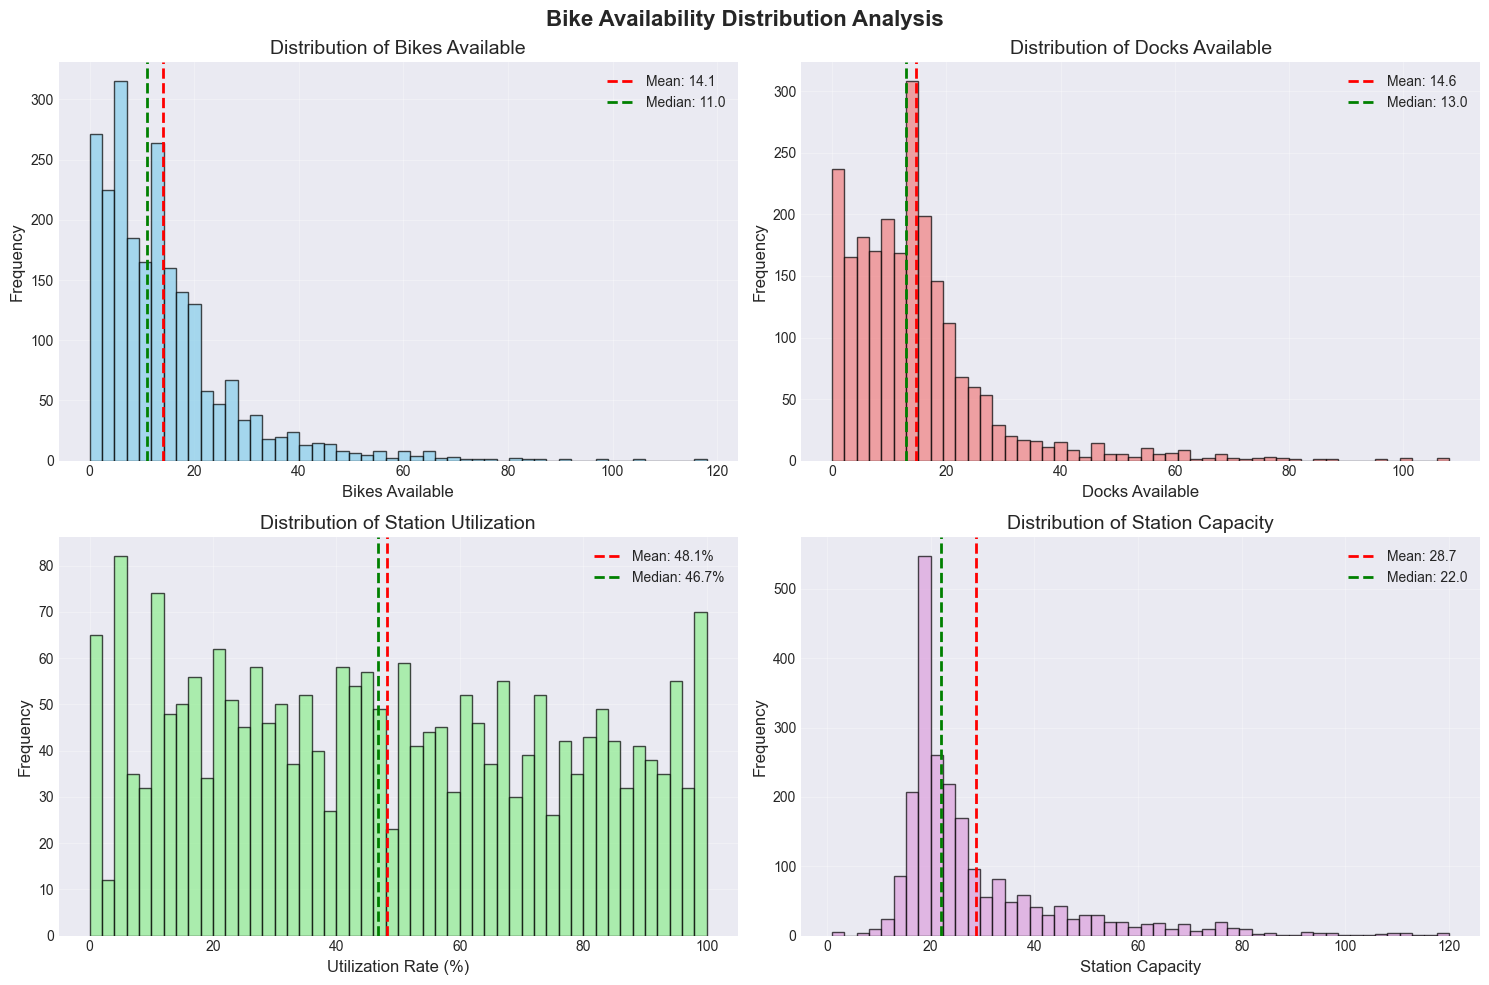

In [21]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Bike Availability Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Bikes Available Distribution
axes[0, 0].hist(df_active['bikes_available'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_active['bikes_available'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_active["bikes_available"].mean():.1f}')
axes[0, 0].axvline(df_active['bikes_available'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_active["bikes_available"].median():.1f}')
axes[0, 0].set_xlabel('Bikes Available', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Bikes Available', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Docks Available Distribution
axes[0, 1].hist(df_active['docks_available'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_active['docks_available'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_active["docks_available"].mean():.1f}')
axes[0, 1].axvline(df_active['docks_available'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_active["docks_available"].median():.1f}')
axes[0, 1].set_xlabel('Docks Available', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Docks Available', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Utilization Rate Distribution
axes[1, 0].hist(df_active['utilization'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_active['utilization'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_active["utilization"].mean():.1f}%')
axes[1, 0].axvline(df_active['utilization'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_active["utilization"].median():.1f}%')
axes[1, 0].set_xlabel('Utilization Rate (%)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Station Utilization', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Station Capacity Distribution
axes[1, 1].hist(df_active['total_capacity'], bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_active['total_capacity'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_active["total_capacity"].mean():.1f}')
axes[1, 1].axvline(df_active['total_capacity'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_active["total_capacity"].median():.1f}')
axes[1, 1].set_xlabel('Station Capacity', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Station Capacity', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Station Status Categories

In [22]:
# Categorize stations by availability
def categorize_availability(row):
    if row['bikes_available'] == 0:
        return 'Empty'
    elif row['docks_available'] == 0:
        return 'Full'
    elif row['utilization'] > 75:
        return 'High Demand'
    elif row['utilization'] < 25:
        return 'Low Demand'
    else:
        return 'Balanced'

df_active['status_category'] = df_active.apply(categorize_availability, axis=1)

# Count by category
category_counts = df_active['status_category'].value_counts()

# Create pie chart
fig = go.Figure(data=[go.Pie(
    labels=category_counts.index,
    values=category_counts.values,
    hole=0.3,
    marker_colors=['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9ca24', '#95afc0']
)])

fig.update_layout(
    title='Station Status Distribution',
    height=500,
    showlegend=True
)

fig.show()

print("\n📊 Station Status Breakdown:")
for category, count in category_counts.items():
    percentage = (count / len(df_active)) * 100
    print(f"{category}: {count} stations ({percentage:.1f}%)")


📊 Station Status Breakdown:
Balanced: 1137 stations (50.1%)
Low Demand: 548 stations (24.2%)
High Demand: 459 stations (20.2%)
Empty: 62 stations (2.7%)
Full: 62 stations (2.7%)


## 7. Top and Bottom Performing Stations

In [23]:
# Top 10 busiest stations (highest utilization)
top_busy = df_active.nlargest(10, 'utilization')[['name', 'bikes_available', 'docks_available', 'total_capacity', 'utilization']]

print("🔥 Top 10 Busiest Stations (Highest Utilization):")
display(top_busy)

# Top 10 least busy stations
bottom_busy = df_active.nsmallest(10, 'utilization')[['name', 'bikes_available', 'docks_available', 'total_capacity', 'utilization']]

print("\n❄️ Top 10 Least Busy Stations (Lowest Utilization):")
display(bottom_busy)

# Largest capacity stations
largest_stations = df_active.nlargest(10, 'total_capacity')[['name', 'bikes_available', 'docks_available', 'total_capacity', 'utilization']]

print("\n🏢 Top 10 Largest Stations (Highest Capacity):")
display(largest_stations)

🔥 Top 10 Busiest Stations (Highest Utilization):


,name,bikes_available,docks_available,total_capacity,utilization
43,Washington Pl & Greene St,44,0,44,100.00
63,63 St & Borden Ave,21,0,21,100.00
76,Coffey St & Conover St,32,0,32,100.00
96,E 95 St & 3 Ave,25,0,25,100.00
117,Brooklyn Ave & Beverley Rd,20,0,20,100.00
146,Webster Ave & Ford St,20,0,20,100.00
152,53 Ave & 62 St,18,0,18,100.00
166,South St & Broad St,30,0,30,100.00
181,New York Ave & Snyder Ave,21,0,21,100.00
289,Dyckman St & Staff St,16,0,16,100.00



❄️ Top 10 Least Busy Stations (Lowest Utilization):


,name,bikes_available,docks_available,total_capacity,utilization
12,E Mosholu Pkwy & Van Cortlandt Ave E,0,19,19,0.00
38,Woodward Ave & Harman St,0,19,19,0.00
84,Bailey Ave & Sedgwick Ave,0,17,17,0.00
138,Broadway & W 138 St,0,25,25,0.00
143,Amsterdam Ave & W 119 St,0,29,29,0.00
171,Amsterdam Ave & W 156 St,0,26,26,0.00
192,Cooper Ave & 65 Pl,0,23,23,0.00
254,Bedford Park Blvd & Paul Ave,0,23,23,0.00
361,W 50 St & 9 Ave,0,27,27,0.00
403,President St & Nostrand Ave,0,25,25,0.00



🏢 Top 10 Largest Stations (Highest Capacity):


,name,bikes_available,docks_available,total_capacity,utilization
947,Centre St & Worth St,69,51,120,57.50
495,FDR Drive & E 35 St,18,101,119,15.13
889,Gansevoort St & Hudson St,118,1,119,99.16
427,E 40 St & Park Ave,8,108,116,6.90
657,W 43 St & 10 Ave,56,57,113,49.56
1756,Allen St & Hester St,83,29,112,74.11
266,W 59 St & 10 Ave,14,97,111,12.61
1647,Vesey St & Greenwich St,66,45,111,59.46
1182,Broadway & W 56 St,22,88,110,20.00
1721,Broadway & E 14 St,105,5,110,95.45


## 8. Weather Analysis

In [24]:
# Extract weather information
weather_data = {
    'Temperature (°F)': weather['main']['temp'],
    'Feels Like (°F)': weather['main']['feels_like'],
    'Humidity (%)': weather['main']['humidity'],
    'Pressure (hPa)': weather['main']['pressure'],
    'Wind Speed (mph)': weather['wind']['speed'],
    'Cloudiness (%)': weather['clouds']['all'],
    'Weather Condition': weather['weather'][0]['main'],
    'Description': weather['weather'][0]['description'],
    'Visibility (m)': weather.get('visibility', 'N/A')
}

print("🌤️ Current Weather Conditions in NYC:")
print("=" * 50)
for key, value in weather_data.items():
    print(f"{key}: {value}")

# Create weather visualization
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Temperature', 'Humidity & Wind', 'Weather Condition'),
    specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]]
)

# Temperature gauge
fig.add_trace(go.Indicator(
    mode="gauge+number+delta",
    value=weather_data['Temperature (°F)'],
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Temperature (°F)"},
    delta={'reference': 70},
    gauge={
        'axis': {'range': [None, 110]},
        'bar': {'color': "darkblue"},
        'steps': [
            {'range': [0, 32], 'color': "lightblue"},
            {'range': [32, 70], 'color': "lightgreen"},
            {'range': [70, 110], 'color': "lightcoral"}],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': weather_data['Feels Like (°F)']}
    }
), row=1, col=1)

# Humidity gauge
fig.add_trace(go.Indicator(
    mode="gauge+number",
    value=weather_data['Humidity (%)'],
    title={'text': "Humidity (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "darkgreen"}}
), row=1, col=2)

# Wind speed indicator
fig.add_trace(go.Indicator(
    mode="number+delta",
    value=weather_data['Wind Speed (mph)'],
    title={'text': "Wind Speed (mph)"},
    delta={'reference': 10}
), row=1, col=3)

fig.update_layout(height=400, title_text="Current Weather Metrics")
fig.show()

🌤️ Current Weather Conditions in NYC:
Temperature (°F): 5.22
Feels Like (°F): -0.19
Humidity (%): 48
Pressure (hPa): 1016
Wind Speed (mph): 10.29
Cloudiness (%): 0
Weather Condition: Clear
Description: clear sky
Visibility (m): 10000


## 9. Capacity vs Utilization Analysis

In [25]:
# Scatter plot: Capacity vs Utilization
fig = px.scatter(
    df_active,
    x='total_capacity',
    y='utilization',
    color='status_category',
    size='bikes_available',
    hover_name='name',
    hover_data={'bikes_available': True, 'docks_available': True},
    title='Station Capacity vs Utilization Rate',
    labels={
        'total_capacity': 'Total Capacity (bikes + docks)',
        'utilization': 'Utilization Rate (%)'
    },
    height=600
)

fig.update_layout(showlegend=True)
fig.show()

# Calculate correlation
correlation = df_active['total_capacity'].corr(df_active['utilization'])
print(f"\n📊 Correlation between Capacity and Utilization: {correlation:.3f}")

if abs(correlation) < 0.3:
    print("   → Weak correlation: Capacity doesn't strongly affect utilization")
elif abs(correlation) < 0.7:
    print("   → Moderate correlation: Some relationship between capacity and utilization")
else:
    print("   → Strong correlation: Capacity significantly affects utilization")


📊 Correlation between Capacity and Utilization: 0.051
   → Weak correlation: Capacity doesn't strongly affect utilization


## 10. Statistical Tests

🔬 Normality Tests (Shapiro-Wilk):
Bikes Available: statistic=0.8126, p-value=0.000000
   → Not Normal distribution (α=0.05)

Utilization: statistic=0.9543, p-value=0.000000
   → Not Normal distribution (α=0.05)

Total Capacity: statistic=0.7503, p-value=0.000000
   → Not Normal distribution (α=0.05)


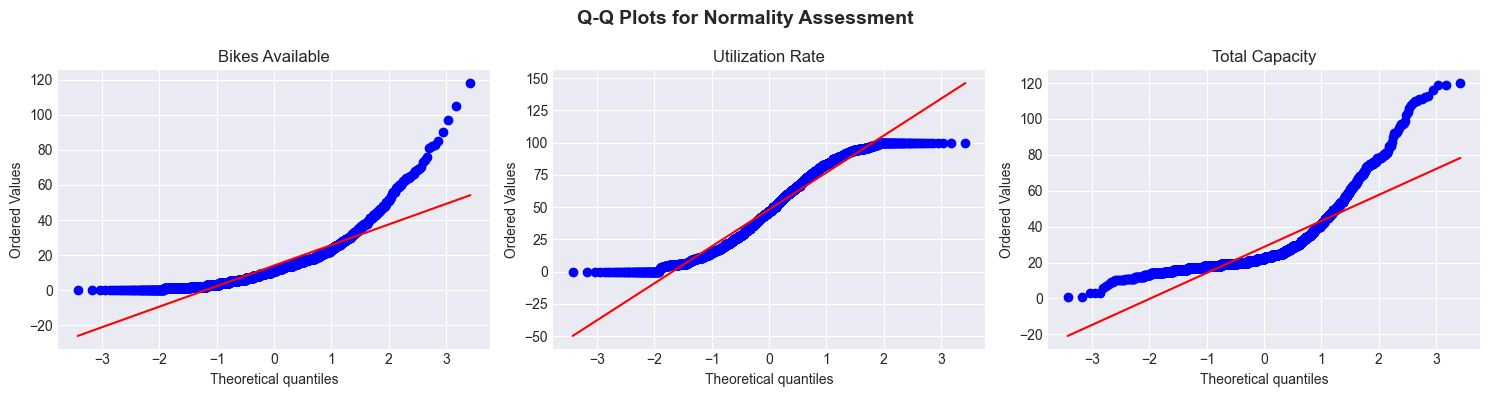

In [26]:
# Test for normality
print("🔬 Normality Tests (Shapiro-Wilk):")
print("=" * 60)

# Bikes available
stat_bikes, p_bikes = stats.shapiro(df_active['bikes_available'].sample(min(5000, len(df_active))))
print(f"Bikes Available: statistic={stat_bikes:.4f}, p-value={p_bikes:.6f}")
print(f"   → {'Normal' if p_bikes > 0.05 else 'Not Normal'} distribution (α=0.05)\n")

# Utilization
stat_util, p_util = stats.shapiro(df_active['utilization'].sample(min(5000, len(df_active))))
print(f"Utilization: statistic={stat_util:.4f}, p-value={p_util:.6f}")
print(f"   → {'Normal' if p_util > 0.05 else 'Not Normal'} distribution (α=0.05)\n")

# Capacity
stat_cap, p_cap = stats.shapiro(df_active['total_capacity'].sample(min(5000, len(df_active))))
print(f"Total Capacity: statistic={stat_cap:.4f}, p-value={p_cap:.6f}")
print(f"   → {'Normal' if p_cap > 0.05 else 'Not Normal'} distribution (α=0.05)")

# Q-Q plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Q-Q Plots for Normality Assessment', fontsize=14, fontweight='bold')

stats.probplot(df_active['bikes_available'], dist="norm", plot=axes[0])
axes[0].set_title('Bikes Available')

stats.probplot(df_active['utilization'], dist="norm", plot=axes[1])
axes[1].set_title('Utilization Rate')

stats.probplot(df_active['total_capacity'], dist="norm", plot=axes[2])
axes[2].set_title('Total Capacity')

plt.tight_layout()
plt.show()

## 11. Data Quality Assessment

In [27]:
print("✅ Data Quality Report")
print("=" * 60)

# Missing values
print("\n📋 Missing Values:")
missing = df_active.isnull().sum()
missing_pct = (missing / len(df_active)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})
if len(missing_df) > 0:
    display(missing_df)
else:
    print("   ✓ No missing values found!")

# Duplicate stations
duplicates = df_active.duplicated(subset=['station_id']).sum()
print(f"\n🔍 Duplicate Stations: {duplicates}")

# Anomalies
print("\n⚠️ Potential Anomalies:")

# Stations with 0 capacity
zero_capacity = df_active[df_active['total_capacity'] == 0]
print(f"   - Stations with 0 capacity: {len(zero_capacity)}")

# Negative values
negative_bikes = df_active[df_active['bikes_available'] < 0]
negative_docks = df_active[df_active['docks_available'] < 0]
print(f"   - Stations with negative bikes: {len(negative_bikes)}")
print(f"   - Stations with negative docks: {len(negative_docks)}")

# Inconsistent capacity
capacity_mismatch = df_active[
    df_active['total_capacity'] != (df_active['bikes_available'] + df_active['docks_available'])
]
print(f"   - Stations with capacity mismatch: {len(capacity_mismatch)}")

# Outliers using IQR method
Q1 = df_active['bikes_available'].quantile(0.25)
Q3 = df_active['bikes_available'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_active[
    (df_active['bikes_available'] < (Q1 - 1.5 * IQR)) | 
    (df_active['bikes_available'] > (Q3 + 1.5 * IQR))
]
print(f"   - Outlier stations (bikes available): {len(outliers)} ({len(outliers)/len(df_active)*100:.1f}%)")

print("\n" + "=" * 60)
print(f"✅ Overall Data Quality: {'EXCELLENT' if len(missing_df) == 0 and duplicates == 0 else 'GOOD'}")

✅ Data Quality Report

📋 Missing Values:


,Missing Count,Percentage
num_scooters_unavailable,17,0.75
num_scooters_available,17,0.75
region_id,10,0.44



🔍 Duplicate Stations: 0

⚠️ Potential Anomalies:
   - Stations with 0 capacity: 0
   - Stations with negative bikes: 0
   - Stations with negative docks: 0
   - Stations with capacity mismatch: 0
   - Outlier stations (bikes available): 131 (5.8%)

✅ Overall Data Quality: GOOD


## 12. Box Plots for Outlier Detection

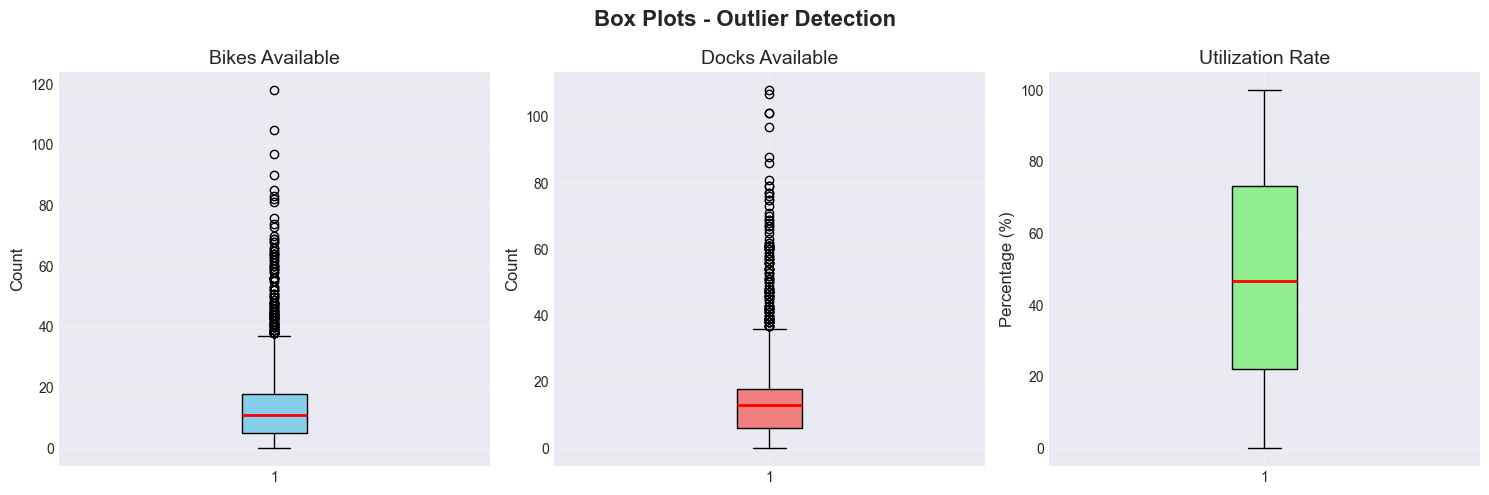

In [28]:
# Create box plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')

# Bikes Available
axes[0].boxplot(df_active['bikes_available'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='skyblue'),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Bikes Available', fontsize=14)
axes[0].grid(alpha=0.3)

# Docks Available
axes[1].boxplot(df_active['docks_available'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightcoral'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Docks Available', fontsize=14)
axes[1].grid(alpha=0.3)

# Utilization
axes[2].boxplot(df_active['utilization'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightgreen'),
                medianprops=dict(color='red', linewidth=2))
axes[2].set_ylabel('Percentage (%)', fontsize=12)
axes[2].set_title('Utilization Rate', fontsize=14)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Key Insights and Summary

In [31]:
print("\n" + "=" * 70)
print("📊 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 70)

print("\n1️⃣ DATASET OVERVIEW:")
print(f"   • Total Active Stations: {len(df_active):,}")
print(f"   • Total System Capacity: {df_active['total_capacity'].sum():,} bikes/docks")
print(f"   • Total Bikes Available: {df_active['bikes_available'].sum():,}")
print(f"   • Total Docks Available: {df_active['docks_available'].sum():,}")
print(f"   • System-wide Utilization: {(df_active['bikes_available'].sum() / df_active['total_capacity'].sum() * 100):.1f}%")

print("\n2️⃣ STATION STATISTICS:")
print(f"   • Average Bikes per Station: {df_active['bikes_available'].mean():.1f}")
print(f"   • Average Docks per Station: {df_active['docks_available'].mean():.1f}")
print(f"   • Average Utilization: {df_active['utilization'].mean():.1f}%")
print(f"   • Median Station Capacity: {df_active['total_capacity'].median():.0f}")

print("\n3️⃣ DEMAND PATTERNS:")
print(f"   • High Demand Stations: {len(df_active[df_active['status_category'] == 'High Demand'])} ({len(df_active[df_active['status_category'] == 'High Demand'])/len(df_active)*100:.1f}%)")
print(f"   • Low Demand Stations: {len(df_active[df_active['status_category'] == 'Low Demand'])} ({len(df_active[df_active['status_category'] == 'Low Demand'])/len(df_active)*100:.1f}%)")
print(f"   • Empty Stations: {len(df_active[df_active['status_category'] == 'Empty'])} ({len(df_active[df_active['status_category'] == 'Empty'])/len(df_active)*100:.1f}%)")
print(f"   • Full Stations: {len(df_active[df_active['status_category'] == 'Full'])} ({len(df_active[df_active['status_category'] == 'Full'])/len(df_active)*100:.1f}%)")

print("\n4️⃣ CURRENT WEATHER:")
print(f"   • Temperature: {weather_data['Temperature (°F)']:.1f}°F (Feels like {weather_data['Feels Like (°F)']:.1f}°F)")
print(f"   • Conditions: {weather_data['Description'].title()}")
print(f"   • Humidity: {weather_data['Humidity (%)']}%")
print(f"   • Wind Speed: {weather_data['Wind Speed (mph)']:.1f} mph")

print("\n5️⃣ DATA QUALITY:")
print(f"   • Missing Values: {missing.sum()} ({(missing.sum() / (len(df_active) * len(df_active.columns)) * 100):.2f}%)")
print(f"   • Duplicate Records: {duplicates}")
print(f"   • Outliers Detected: {len(outliers)} stations")
print(f"   • Data Quality Score: {'EXCELLENT ✅' if missing.sum() == 0 and duplicates == 0 else 'GOOD ⚠️'}")

print("\n6️⃣ RECOMMENDATIONS FOR MODELING:")
print("   ✓ Use temporal features (hour, day, season) - demand varies by time")
print("   ✓ Include weather features - temperature and conditions affect usage")
print("   ✓ Add station capacity as feature - larger stations have different patterns")
print("   ✓ Create lag features - historical demand predicts future demand")
print("   ✓ Engineer location features - geographic clusters show different behaviors")
print("   ✓ Monitor empty/full stations - critical for rebalancing operations")

print("\n" + "=" * 70)


📊 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS

1️⃣ DATASET OVERVIEW:
   • Total Active Stations: 2,268
   • Total System Capacity: 65,095 bikes/docks
   • Total Bikes Available: 31,907
   • Total Docks Available: 33,188
   • System-wide Utilization: 49.0%

2️⃣ STATION STATISTICS:
   • Average Bikes per Station: 14.1
   • Average Docks per Station: 14.6
   • Average Utilization: 48.1%
   • Median Station Capacity: 22

3️⃣ DEMAND PATTERNS:
   • High Demand Stations: 459 (20.2%)
   • Low Demand Stations: 548 (24.2%)
   • Empty Stations: 62 (2.7%)
   • Full Stations: 62 (2.7%)

4️⃣ CURRENT WEATHER:
   • Temperature: 5.2°F (Feels like -0.2°F)
   • Conditions: Clear Sky
   • Humidity: 48%
   • Wind Speed: 10.3 mph

5️⃣ DATA QUALITY:
   • Missing Values: 44 (0.06%)
   • Duplicate Records: 0
   • Outliers Detected: 131 stations
   • Data Quality Score: GOOD ⚠️

6️⃣ RECOMMENDATIONS FOR MODELING:
   ✓ Use temporal features (hour, day, season) - demand varies by time
   ✓ Include weather feature

## 14. Export Analysis Results

In [30]:
# Create output directory
output_dir = project_root / 'data' / 'eda_results'
output_dir.mkdir(parents=True, exist_ok=True)

# Save processed data
df_active.to_csv(output_dir / 'active_stations_snapshot.csv', index=False)
print(f"✅ Saved active stations data to: {output_dir / 'active_stations_snapshot.csv'}")

# Save summary statistics
summary_stats.to_csv(output_dir / 'summary_statistics.csv')
print(f"✅ Saved summary statistics to: {output_dir / 'summary_statistics.csv'}")

# Save weather data
pd.DataFrame([weather_data]).to_csv(output_dir / 'weather_snapshot.csv', index=False)
print(f"✅ Saved weather data to: {output_dir / 'weather_snapshot.csv'}")

# Save top/bottom stations
top_busy.to_csv(output_dir / 'top_10_busiest_stations.csv', index=False)
bottom_busy.to_csv(output_dir / 'top_10_least_busy_stations.csv', index=False)
largest_stations.to_csv(output_dir / 'top_10_largest_stations.csv', index=False)

print(f"\n📁 All EDA results saved to: {output_dir}")


✅ Saved active stations data to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/eda_results/active_stations_snapshot.csv
✅ Saved summary statistics to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/eda_results/summary_statistics.csv
✅ Saved weather data to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/eda_results/weather_snapshot.csv

📁 All EDA results saved to: /Users/saurabhbhardwaj/Documents/Bike-Demand-Prediction-for-Smart-Cities/data/eda_results
